# Multi-variate communication with pointers

This sketch shows how a single wire can transmit an array through a pointer. Only the readout and dynamics function is used to transmit the information.

In [1]:
# Libraries
using AlgebraicDynamics
using AlgebraicDynamics.DWDDynam
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using Plots
using Plots.PlotMeasures
using DifferentialEquations

In [2]:
show_diagram(d::WiringDiagram) = to_graphviz(d,
  orientation=LeftToRight,
  labels=true, label_attr=:xlabel,
  node_attrs=Graphviz.Attributes(
    :fontname => "Helvetica",
  ),
  edge_attrs=Graphviz.Attributes(
    :fontname => "Helvetica",
  )
);

### Part 1 - Two boxes

Consider a system with two boxes. A single wire will transmit the state of box1 into box2 and vice versa. 

In [3]:
#- Coefficients
# Mass #1
k1 = 1;     
c1 = 1;

# Mass #2
k2 = 1; 
c2 = 4;

# Parameters for ODE Solver:
u_init = [1, 0, 1, 0];       # Initial conditions: [x1, v1, x2, v2]
t_span = (0, 20);            # Interval of solution

# Miscellaneous:
const N_STATES = 2;          # Number of states transmitter per wire

To transfer information, the readout function can output the pointer of the state vector as a number. In the dynamics function, this address is turned into a pointer which is used to access the state vector. 

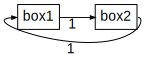

In [4]:
# Closed diagram
diagram = WiringDiagram( [], [] );  

# Boxes
box1 = add_box!( diagram, Box(:box1, [:1], [:1]) );
box2 = add_box!( diagram, Box(:box2, [:1], [:1]) );

# Connections
add_wires!(diagram, [
    (box1,1) => (box2,1)
    (box2,1) => (box1,1)
])

show_diagram(diagram)

In this case, the readout and dynamics functions are the same for both boxes as they have the same number of inputs and outputs.

In [5]:
#- Readout functions: r(u)
function readout1(u)
    return [ Float64( UInt64(pointer(u)) ) ];   # Each box outputs the address of the state pointer
end

function readout2(u)
    return [ Float64( UInt64(pointer(u)) ) ];
end

#- Input Functions: 
common_term(u, x) = k2*(x[1] - u[1]) + c2*(x[2] - u[2]);     
                        
function equation1(u, x, p, t)                  # Each equation must decode the input
    # Convert adress to a pointer
    pt = Ptr{Float64}( UInt64(x[1]) );
    
    # Retrieve the state vector
    x = unsafe_wrap(Vector{Float64}, pt, N_STATES, own=false);

    return [ u[2], -k1*u[1] - c1*u[2] + common_term(u,x)];   
end

function equation2(u, x, p, t) 
    # Input:
    pt = Ptr{Float64}( UInt64(x[1]) );    
    x = unsafe_wrap(Vector{Float64}, pt, N_STATES, own=false);   
    
    return [ u[2], common_term(u,x) ]; 
end

equation2 (generic function with 1 method)

This scheme works as the velocity of each box is communicated succesfully.

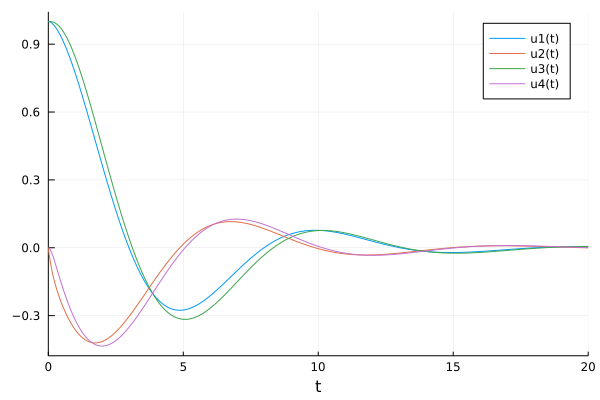

In [6]:
# Machines:
                                  # Inputs, States, Outputs
box1_machine = ContinuousMachine{Float64}( 1, 2, 1, equation1, readout1 );    
box2_machine = ContinuousMachine{Float64}( 1, 2, 1, equation2, readout2 );  

# Compose
net_machine = oapply(diagram, [box1_machine, box2_machine]);

# Convert into ODE form:
data = ODEProblem(net_machine, u_init, t_span);

# Solve and plot system
sol = solve( data, alg_hints=[:stiff] );
plot(sol)